In [2]:
!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np
import pandas as pd

from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=60c5c5d28936a0c3eca12736c053c3abde77ba0dbe94583cbe4345db047e07b8
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [3]:
# The dataset is available at: https://www.kaggle.com/puneet6060/intel-image-classification
# Too big to upload it on moodle.
# Details about the DS in the presentation. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# hyperparams
batch_size = 8
im_size = 150
lr = 0.0001
# recommended mean and std of the dataset
mean = np.array([0.43018347, 0.4574792, 0.45386416])
std = np.array([0.23611864, 0.23468062, 0.24323046])
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size, im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/seg_train', transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

In [6]:
# image transformations for train and test data
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # ImageNet standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#inverse normalization for image plots, since the originals have been normalized already
inv_normalize =  transforms.Normalize(mean = -1 * np.divide(mean,std), std = 1 / std)

In [11]:
def data_loader(train_data,test_data = None , valid_size = None , batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    data_len = len(test_data)
    indices = list(range(data_len))
    np.random.shuffle(indices)
    split1 = int(np.floor(valid_size * data_len))
    valid_idx , test_idx = indices[:split1], indices[split1:]
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
    test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
    dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
    return dataloaders

In [12]:
#data loaders
train_data = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/seg_train/seg_train', transform = train_transforms)
test_data = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/seg_test/seg_test', transform = test_transforms)
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
classes = train_data.classes
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
print(len(train_data))
print(len(test_data))

14034
3000


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


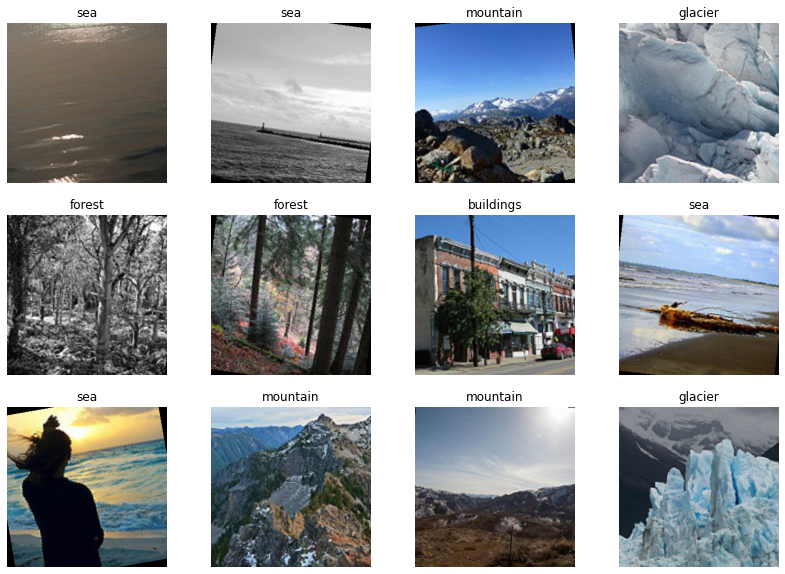

In [13]:
import matplotlib.pyplot as plt
import random
# plotting random images from dataset
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if inv_normalize != None:
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)


# Declare model

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.net =  EfficientNet.from_pretrained('efficientnet-b0')
        # self.net = models.resnet50(pretrained = True)
        # self.net = models.vgg16(pretrained = True)
        self.l1 = nn.Linear(1000, 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,6)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.net(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier().to(device)
criterion = nn.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b0


In [15]:
import numpy as np
import torch
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [16]:
def train(model,dataloaders,criterion,num_epochs=10,lr=0.0001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    print(phase1)
    losses = list()
    acc = list()
    if patience != None:
        earlystop = EarlyStopping(patience = patience)
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr * 0.8
        if(epoch % 10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [17]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [18]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()

def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:' + c + ',' + 'P:' + w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [19]:
def train_model(model,dataloaders,criterion,num_epochs=10,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

dict_keys(['train', 'val'])
Epoch: 0
train Epoch: 0  [0/14034 (0%)]	Loss: 1.780469 	Acc: 0.375000
train Epoch: 0  [2400/14034 (17%)]	Loss: 0.368344 	Acc: 0.870847
train Epoch: 0  [4800/14034 (34%)]	Loss: 0.319763 	Acc: 0.889351
train Epoch: 0  [7200/14034 (51%)]	Loss: 0.301485 	Acc: 0.896088
train Epoch: 0  [9600/14034 (68%)]	Loss: 0.281485 	Acc: 0.901228
train Epoch: 0  [12000/14034 (85%)]	Loss: 0.272505 	Acc: 0.903981
False
val Epoch: 0  [0/3000 (0%)]	Loss: 0.015600 	Acc: 1.000000
Validation loss decreased (inf --> 0.230991).  Saving model ...
False
val Accuracy:  0.9116666666666667
Epoch: 1
train Epoch: 1  [0/14034 (0%)]	Loss: 0.056998 	Acc: 1.000000
train Epoch: 1  [2400/14034 (17%)]	Loss: 0.196494 	Acc: 0.930648
train Epoch: 1  [4800/14034 (34%)]	Loss: 0.182453 	Acc: 0.934484
train Epoch: 1  [7200/14034 (51%)]	Loss: 0.180568 	Acc: 0.936043
train Epoch: 1  [9600/14034 (68%)]	Loss: 0.180537 	Acc: 0.936615
train Epoch: 1  [12000/14034 (85%)]	Loss: 0.182749 	Acc: 0.936043
False
val Ep

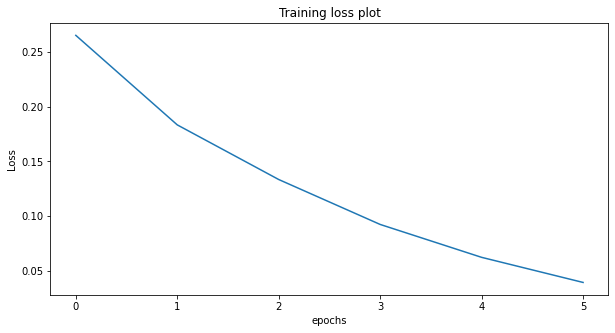

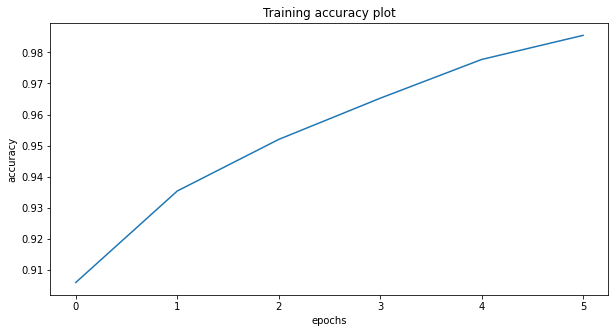

tensor(0.9117, device='cuda:0', dtype=torch.float64) 0.2548573223998149
Classes in order Actual and Predicted


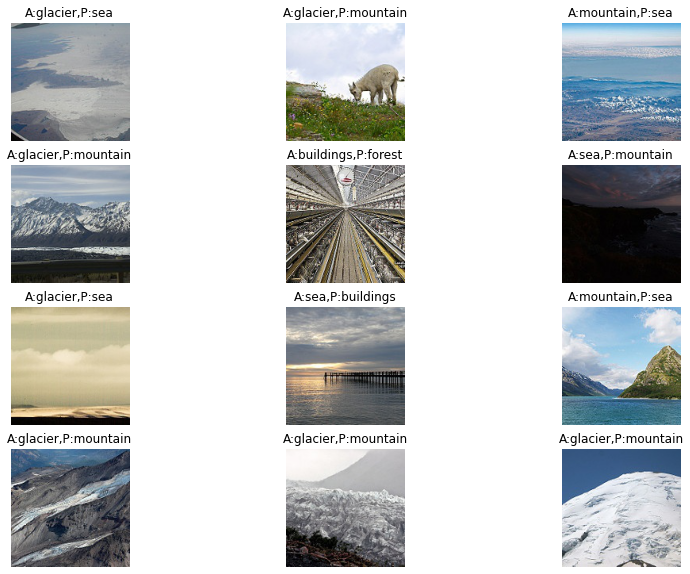

Precision: 91.47095846001893 Recall: 91.3776254176355, Accuracy: 91.16666666666666: ,f1_score: 91.29593098402037
Confusion matrix, without normalization
[[318   2   0   1   1  31]
 [  0 365   2   2   1   3]
 [  1   4 346  73  12   2]
 [  1   0  23 378  11   1]
 [ 11   0   6   4 396   0]
 [ 16   0   0   2   2 385]]


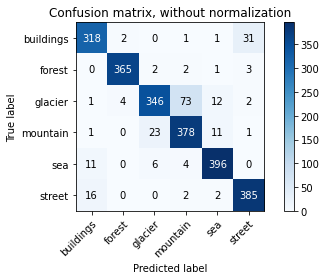

In [ ]:
train_model(classifier,dataloaders,criterion, num_epochs=10, lr = 0.0001, patience = 3 , batch_size = batch_size , classes = classes)

In [ ]:
from PIL import Image
import numpy as np
import cv2

def predict(model,image,device,encoder,transforms = None,inv_normalize = None):
    model.eval()
    if(isinstance(image,np.ndarray)):
      image = Image.fromarray(image)
    if(transforms!=None):
        image = transforms(image)
    data = image.expand(1,-1,-1,-1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim = 1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image,inv_normalize)
    prediction_bar(output,encoder)
    return preds

def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]
    size = len(a)
    if(size>5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
      prediction.append(float(output[:,i]*100))
      clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    plt.bar(clas,prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")
 
def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()


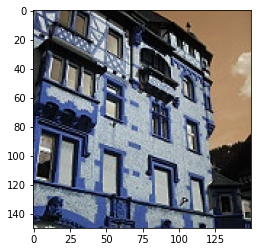

Class: buildings , confidence: 99.96329498291016
Class: street , confidence: 0.03643263876438141
Class: glacier , confidence: 0.0002618002472445369
Class: forest , confidence: 2.2275112314673606e-06
Class: sea , confidence: 8.79524918673269e-07


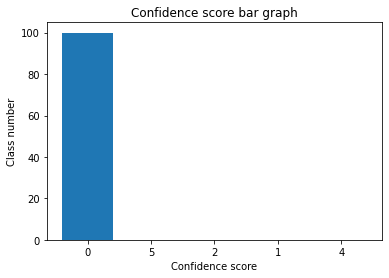

In [ ]:
image = cv2.imread('/content/drive/MyDrive/seg_pred/seg_pred/12347.jpg')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)